# Multi-task learning with fastai

In this tutorial, we cover multi-task learning with fastai, specifically, we train a video distortion detection model.

We train our model on a small subset of VSQuaD dataset \[1\], which consists of 1332 surveillance videos with 9 types of distortions and 36 reference videos without any distortions. Each video is 10 second long. We split each video into 1 second long clips and sample 5 frames from each clip.

Our model takes a set of video frames which contains a type of distortion as input and outputs distortion class and severity level. 
Since the model makes multiple types of predictions for a given data point, it's a multi-task learning problem.

In [ ]:
#all_skip

In [ ]:
#hide
#skip
%%shell

pip install --upgrade --force-reinstall --no-deps kaggle
pip install -Uqq fastai==2.5.5 nbdev
pip install -Uqq fastmtl

In [ ]:
#hide
from pathlib import Path
import numpy as np
import pandas as pd
import torch.nn as nn
from fastai.vision.all import *

SEED = 42
set_seed(SEED)

## Data

[The subset of VSQuaD dataset](https://www.kaggle.com/datasets/bdsaglam/vsquadtiny480x270) is hosted on Kaggle. We can download it from Kaggle website or via Kaggle CLI.

In [ ]:
#hide
#skip
import os
from getpass import getpass

os.environ['KAGGLE_USERNAME'] = input("Your Kaggle username:")
os.environ['KAGGLE_KEY'] = getpass("Your Kaggle token:")

In [ ]:
#hide
#skip
%%shell

# We will download it by Kaggle CLI.

kaggle datasets download -d "bdsaglam/vsquadtiny480x270" 
unzip "vsquadtiny480x270.zip" > /dev/null
rm "vsquadtiny480x270.zip"
ls -l

 99% 711M/718M [00:04<00:00, 149MB/s]
100% 718M/718M [00:04<00:00, 153MB/s]
total 24
drwxr-xr-x 467 root root 20480 Jul  9 21:13 frames
drwxr-xr-x   1 root root  4096 Jul  6 13:22 sample_data


## Dataset

The dataset is organized by folders for video's frames. Each folder has 10 video frames in jpeg format. The size of a frame is 480x270. The folder name contain scene, distortion class and severity level labels. There are 5 frames in 1 second video clip. Hence, we'll split the video frames per second and perform classification for each clip.
We split the dataset into train and validation splits by strafying on video label. To prevent data leakage, the split is performed before videos are splitted into clips. In other words, all frames of a video are only in either of train and validation sets.
Then, we create a dataframe where each row corresponds to a second long video clip and its labels. 


In [ ]:
#hide
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [ ]:
#hide
import re
from pathlib import Path
import pandas as pd
from fastcore.basics import *
from fastcore.xtras import *
from sklearn.model_selection import train_test_split

def parse_distortion_severity(video_name):
    distortion, severity = video_name.split('_D')[1].split('_')
    return f'D{distortion}', f'S{severity}'

def label_dataframe(df):
    df['label'] = df['video_name'].apply(parse_distortion_severity)
    df['distortion'] = df['label'].apply(lambda t: t[0])
    df['severity'] = df['label'].apply(lambda t: t[1])
    return df

def make_dataframe_splitter(valid_pct, strata='label'):
    def stratified_split(df):
        _, val_index = train_test_split(df.index, test_size=valid_pct, stratify=df[strata])
        df['is_valid'] = False
        df.loc[val_index, 'is_valid'] = True
        return df
    return stratified_split

def populate_frames(df, frame_indices_list):
    for frame_indices in frame_indices_list:
        df = df.copy()
        df['frames'] = [frame_indices]*len(df)
        df['frame_paths'] = df['video_path'].apply(lambda vn: [str(Path(vn) / f"{i}.jpg") for i in frame_indices])
        yield df

def make_framer(frame_indices_list):
    return lambda dataf: pd.concat(list(populate_frames(dataf, frame_indices_list)), axis=0)

def make_dataframe(root):
    video_paths = sorted([str(p) for p in Path(root).ls() if not p.name.startswith('.')])
    df = pd.DataFrame(data=dict(video_path=video_paths))
    df['video_name'] = df['video_path'].apply(lambda p: Path(p).name)
    return df

def make_train_dataframe(root, valid_pct, frame_indices_list):
    return (
        make_dataframe(root)
        .pipe(label_dataframe)
        .pipe(make_dataframe_splitter(valid_pct))
        .pipe(make_framer(frame_indices_list))
    )

In [ ]:
#hide_input
df = make_train_dataframe('./frames', 0.2, np.arange(25).reshape(-1, 5).tolist())
df[['video_name', 'label', 'distortion', 'severity', 'is_valid', 'frames']]

video_name     label distortion severity  is_valid           frames
0  airport_D0_0  (D0, S0)         D0       S0     False  [0, 1, 2, 3, 4]
1  airport_D1_1  (D1, S1)         D1       S1     False  [0, 1, 2, 3, 4]
2  airport_D1_2  (D1, S2)         D1       S2     False  [0, 1, 2, 3, 4]
3  airport_D1_3  (D1, S3)         D1       S3     False  [0, 1, 2, 3, 4]
4  airport_D1_4  (D1, S4)         D1       S4     False  [0, 1, 2, 3, 4]

There are 5 distortion types in this subset of VSQuaD dataset and 4 severity levels. The reference videos, i.e. the videos with no distortion, has `D0` label for distortion and `S0` label for severity. Hence, there are 6 distortion classes and 5 severity classes to be predicted by the model. Since each video has only one type of distortion, this is a single-label multi-class classification problem.

In [ ]:
#hide_input
print("Size of train set:\t", len(df[~df.is_valid]))
print("Size of validation set:\t", len(df[df.is_valid]))

Size of train set:	 1860
Size of validation set:	 465


Distortion types:

In [ ]:
#hide_input
L(df.distortion.unique().tolist())

(#7) ['D0','D1','D5','D7','D8','D2','D6']

Severity levels:

In [ ]:
#hide_input
L(df.severity.unique().tolist())

(#5) ['S0','S1','S2','S3','S4']

## Dataloaders

Since the model input is video frames, we will create an ImageTuple type and ImageTupleBlock, similar to [this fastai tutorial](https://docs.fast.ai/tutorial.image_sequence.html#:~:text=class%20ImageTuple(fastuple)).

In [ ]:
#collapse-hide
from fastai.vision.all import *
from fastcore.basics import fastuple

class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns):
        return cls(tuple(PILImage.create(fn) for fn in fns))

    def show(self, ctx=None, **kwargs):
        t1 = self[0]
        if isinstance(t1, PILImage):
            return self._show_pil(ctx, **kwargs)
        elif isinstance(t1, Tensor):
            return self._show_tensor(ctx, **kwargs)
        else:
            return ctx

    def _show_pil(self, ctx, **kwargs):
        t1 = np.asarray(self[0])
        line = np.zeros((t1.shape[0], 10, t1.shape[2]), dtype=np.uint8)
        img = PILImage.create(np.concatenate([x for img in self for x in (np.asarray(img), line)][:-1], axis=1))
        return show_image(img, ctx=ctx, **kwargs)

    def _show_tensor(self, ctx, **kwargs):
        t1 = self[0]
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([x for img in self for x in (img, line)][:-1], dim=2), ctx=ctx, **kwargs)

    @property
    def shape(self):
        t1 = self[0]
        if isinstance(t1, Tensor):
            return t1.shape
        if isinstance(t1, PILImage):
            return np.array(t1).shape
        return t1.shape

def ImageTupleBlock():
    return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [ ]:
#collapse-hide
import random

BS = 16

db = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock, CategoryBlock),
    splitter=ColSplitter('is_valid'),
    get_x=ColReader('frame_paths'),
    get_y=[ColReader('distortion'), ColReader('severity')],
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats)
    ],
    n_inp=1
)
dls = db.dataloaders(df, bs=BS)

Here are frames for a few video clips.

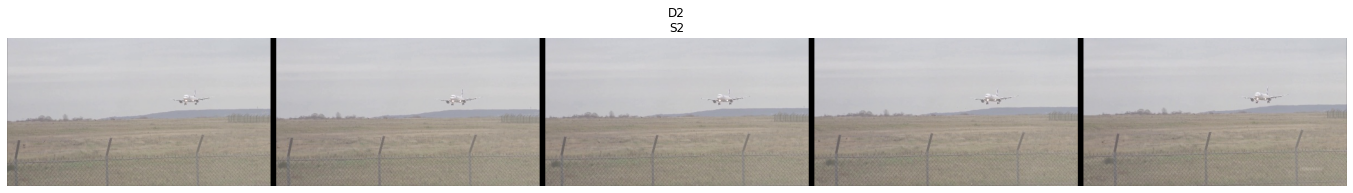

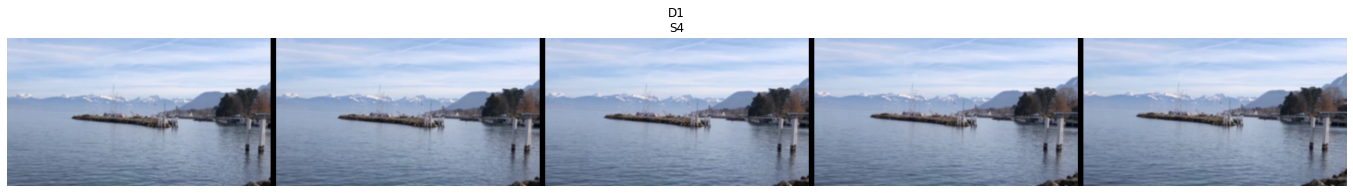

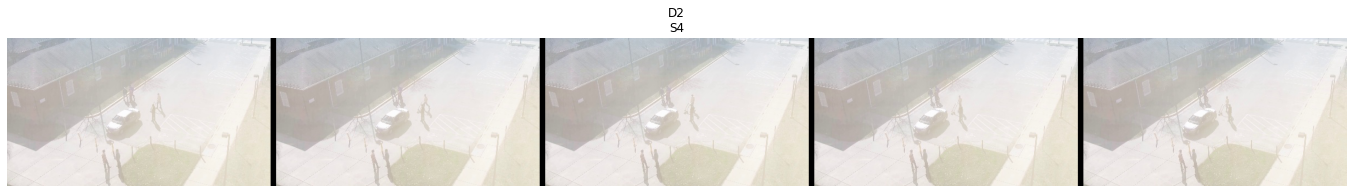

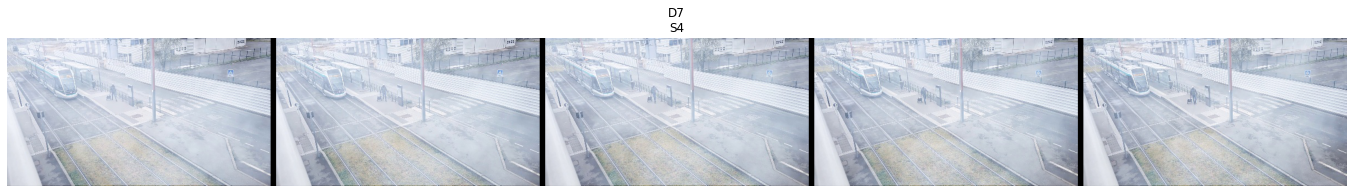

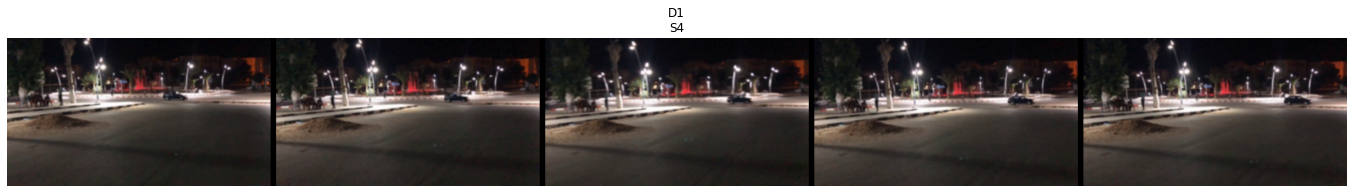

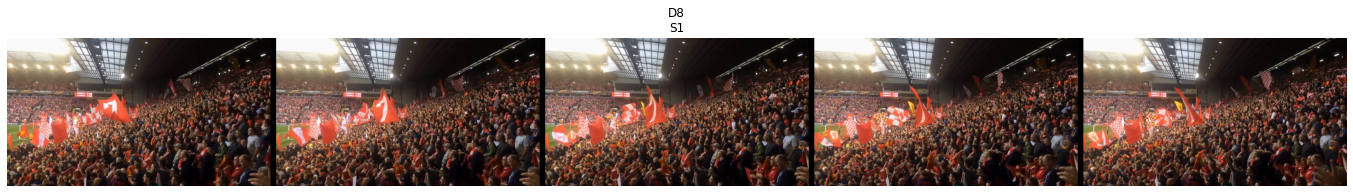

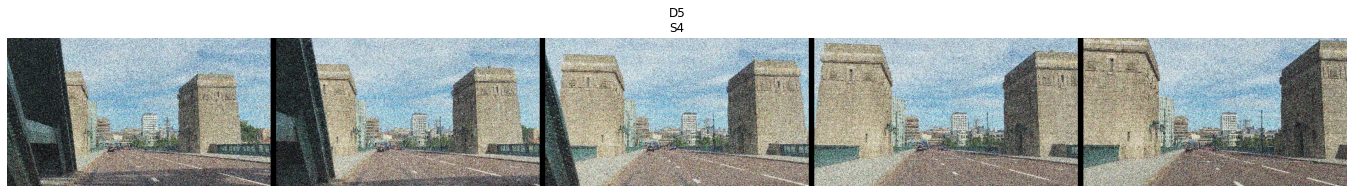

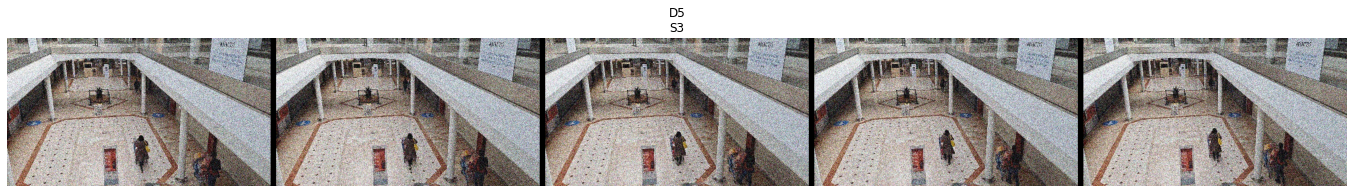

In [ ]:
#hide_input
dls.show_batch(max_n=8, figsize=(24, 12))

In [ ]:
#hide
x, y1, y2 = dls.one_batch()
x.shape, y1.shape, y2.shape

(torch.Size([16, 3, 270, 480]), torch.Size([16]), torch.Size([16]))

## Training

We use a simple CNN to classify distortion and severity level of frames. The model uses a pretrained ResNet18 model as backbone and has a classification head outputs logits per distortion and severity level. Since there are multiple images fed into the model, it averages logits over all frames.

In [ ]:
#collapse-hide
from fastai.callback.hook import model_sizes

def get_num_features(module):
    return model_sizes(module, size=(300, 300))[-1][1]

class NaiveModel(Module):
    def __init__(self, arch, n_distortion, n_severity, pretrained=True):
        store_attr()
        self.encoder = TimeDistributed(create_body(arch, pretrained=pretrained))
        self.head = TimeDistributed(create_head(get_num_features(self.encoder.module), n_distortion + n_severity))
    
    def forward(self, x):
        feature_map = self.encoder(torch.stack(x, dim=1))
        out = self.head(feature_map).mean(dim=1)
        return [out[:, :self.n_distortion], out[:, self.n_distortion:]]
   
    @staticmethod
    def splitter(model): 
        return [params(model.encoder), params(model.head)]

model = NaiveModel(arch=resnet18, n_distortion=len(dls.vocab[0]), n_severity=len(dls.vocab[1])).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We will use cross-entropy losses for both distortion and severity. Since it's more difficult to detect severity of a distortion, we set the weight of severity classification loss higher than distortion loss. `fastmtl` provides a utility class, [`CombinedLoss`](https://bdsaglam.github.io/fastmtl/loss.html#CombinedLoss), which computes weighted sum of losses for each type of prediction that the model makes. It also preserves `decodes` and `activation` functions of fastai loss classes so that raw logits can be decoded.


In [ ]:
from fastmtl.loss import CombinedLoss
loss_func = CombinedLoss(CrossEntropyLossFlat(), CrossEntropyLossFlat(), weight=[1.0, 3.0])

We will evaluate the model with F1-macro and F1-micro metrics for distortion; and accuracy metric for severity. fastai already provides these metrics; but, they expect single prediction tensor and single target. Whereas, our model produces a tuple of prediction tensors for distortion and severity level. We can work around this by defining a function for each metric we use and make them pick the right prediction, such as

```
def distortion_f1_macro(preds, *targets):
    return F1Score(average='macro')(preds[0].argmax(dim=-1), targets[0])

def distortion_f1_micro(preds, *targets):
    return F1Score(average='micro')(preds[0].argmax(dim=-1), targets[0])

def severity_accuracy(preds, *targets):
    return accuracy(preds[1], targets[1])
```
However, this is repetitive and more importantly, it converts class-based metrics to functional metrics, which behaves differently in fastai. For instance, in `distortion_f1_macro`, we have to apply argmax ourselves, which wouldn't be the case, if we were able to use `F1Score` directly. 

`fastmtl` provides a few utilities for metrics to solve these problems. `mtl_metrics` function routes model predictions to the metrics provided by their order. For instance, for distortion, it routes the first output of model to the metrics in the first argument, thus to F1-macro and accuracy metrics. Check out [the documentation](https://bdsaglam.github.io/fastmtl/metric.html) if you are interested in more details on this.

In [ ]:
from fastmtl.metric import mtl_metrics
from copy import copy

distortion_f1_macro =  F1Score(average='macro')
distortion_f1_macro.name = 'distortion_f1(macro)'
distortion_f1_micro =  F1Score(average='micro')
distortion_f1_micro.name = 'distortion_f1(micro)'

severity_accuracy = accuracy

metrics = mtl_metrics([distortion_f1_macro, distortion_f1_micro], [severity_accuracy])
metrics[2].__name__ = 'severity_accuracy'

learn = Learner(
    dls, 
    model,
    loss_func=loss_func,
    metrics=metrics,
    splitter=model.splitter,
    cbs = [SaveModelCallback()],
)
if DEVICE.type!='cpu':
    learn = learn.to_fp16()
learn.freeze()

In [ ]:
#collapse-hide
import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning, module=r'.*')
    learn.fit_one_cycle(10, 3e-4)

Better model found at epoch 0 with valid_loss value: 4.308225631713867.
Better model found at epoch 2 with valid_loss value: 4.264246463775635.
Better model found at epoch 3 with valid_loss value: 4.176193714141846.
Better model found at epoch 9 with valid_loss value: 4.1724534034729.


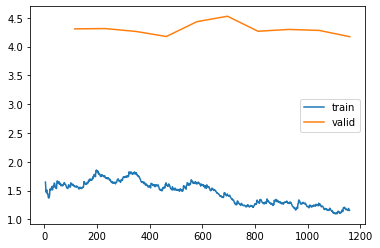

In [ ]:
#hide
learn.recorder.plot_loss()

## Evaluation

Let's evaluate the model on validation set and visualize results.

In [ ]:
#hide
learn = learn.load('model')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


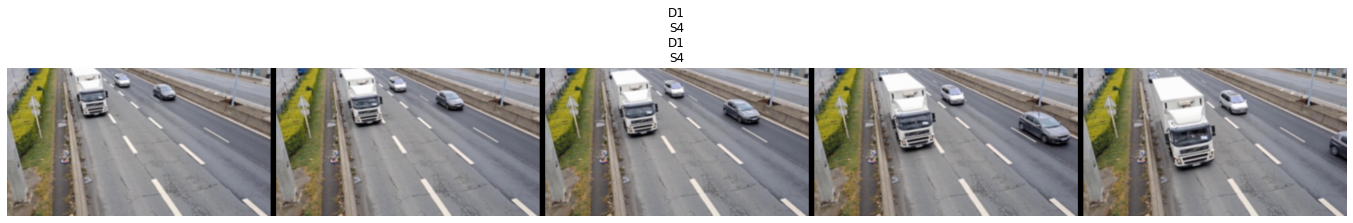

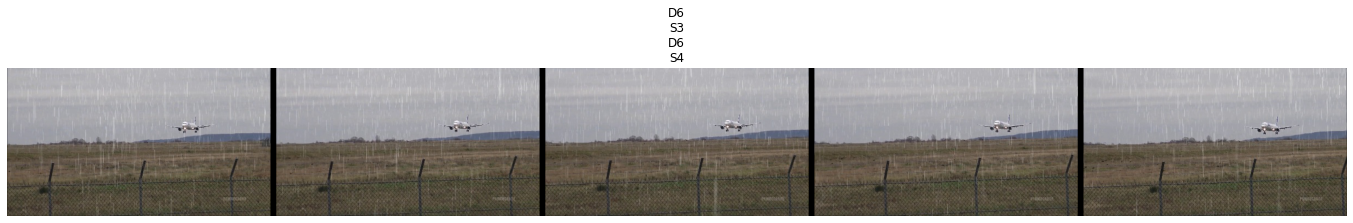

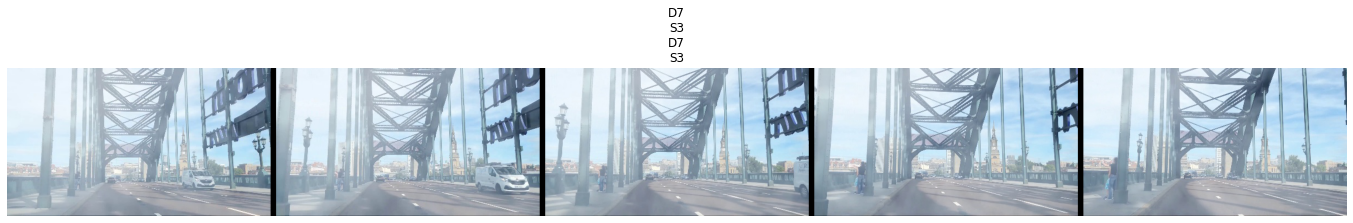

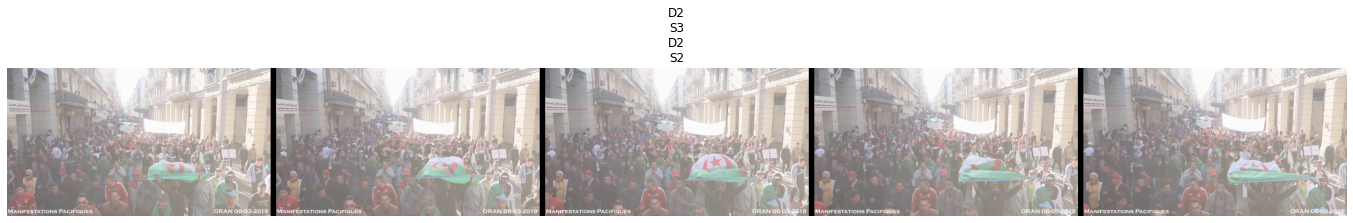

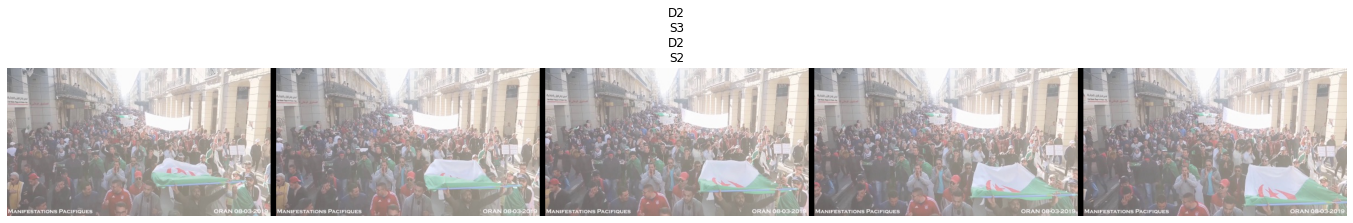

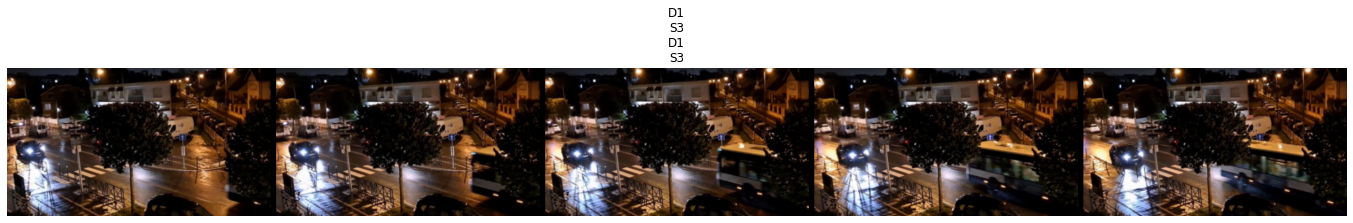

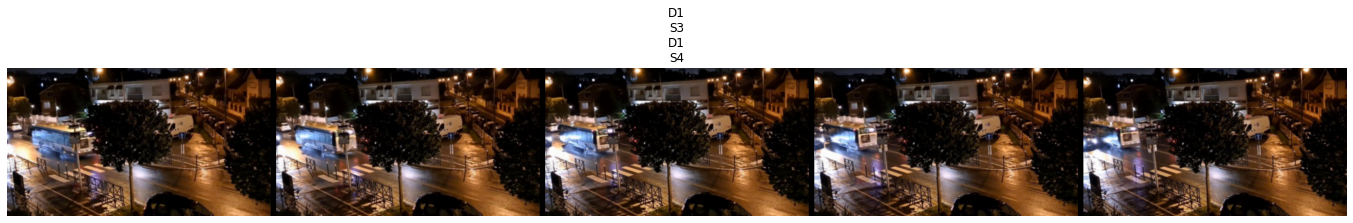

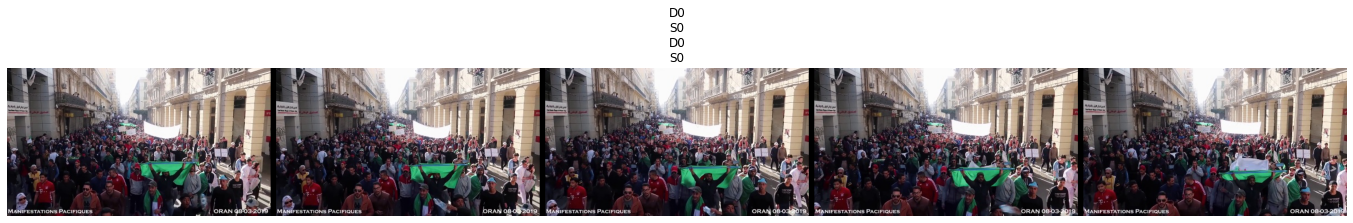

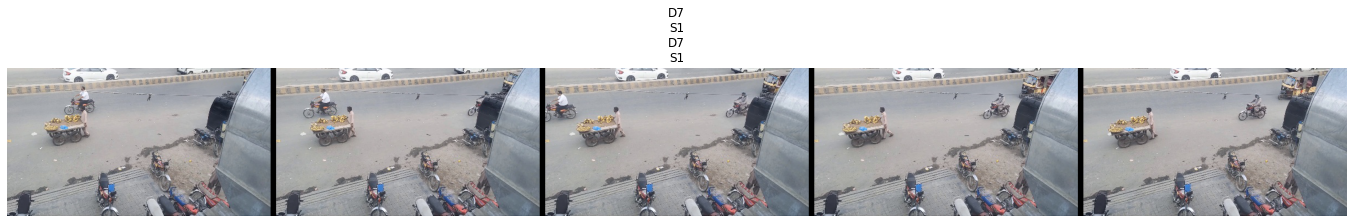

In [ ]:
#hide_input
learn.show_results(figsize=(24, 12))

Now, let's check model performance per distortion class and per severity level.

              precision    recall  f1-score   support

          D0       0.38      0.40      0.39        25
          D1       1.00      0.97      0.98       100
          D2       0.98      1.00      0.99        50
          D5       1.00      1.00      1.00       100
          D6       0.78      0.80      0.79        50
          D7       1.00      0.96      0.98       100
          D8       0.80      0.88      0.83        40

    accuracy                           0.92       465
   macro avg       0.85      0.86      0.85       465
weighted avg       0.92      0.92      0.92       465

              precision    recall  f1-score   support

          S0       0.29      0.24      0.26        25
          S1       0.39      0.44      0.41       110
          S2       0.32      0.28      0.29       105
          S3       0.36      0.26      0.30       115
          S4       0.52      0.68      0.59       110

    accuracy                           0.40       465
   macro avg       0.37

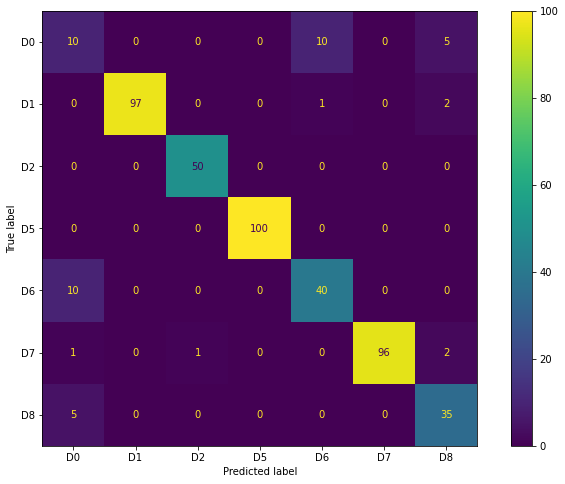

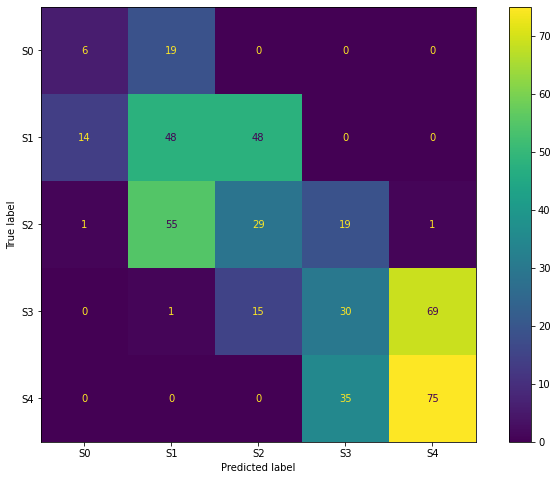

In [ ]:
#collapse-hide
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning, module=r'.*')

def clf_report(learn, dl, vocabs):
    probs, targets, preds = learn.get_preds(dl=dl, with_decoded=True)
    
    for i, (vocab, target, pred) in enumerate(zip(vocabs, targets, preds)):
        label_indices = list(range(len(vocab)))
        y_true, y_pred = target.cpu().numpy(), pred.cpu().numpy()
        print(classification_report(y_true, y_pred, labels=label_indices, target_names=vocab))

        fig, ax = plt.subplots(figsize=(12, 8))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=label_indices, display_labels=vocab, ax=ax)
    
    distortion_f1_macro_val = F1Score(average='macro')(preds[0], targets[0])
    distortion_accuracy_val = accuracy(probs[0], targets[0])
    severity_accuracy_val = accuracy(probs[1], targets[1])
    return dict(
        distortion_f1_macro_val=distortion_f1_macro_val,
        distortion_accuracy_val=distortion_accuracy_val,
        severity_accuracy_val=severity_accuracy_val,
    )

scores = clf_report(learn, dls.valid, dls.vocab)

## Conclusion

Multi-task learning has been becoming more common in ML research and production since it motivates more capable and generalizable models. In this tutorial, we introduced `fastmtl` library offering utilities to make MTL with fastai easier.

## References
1. Zohaib Amjad Khan et al., “Video distortion detection and classification in the context of video surveillance,” in Inter- national Conference on Image Processing (ICIP) Grand Chal- lenge Session, 2022.